# Kaggle Project

## MIT-BIH Arrhythmia Database
The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979.  Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range.  Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable reference annotations for each beat (approximately 110,000 annotations in all) included with the database.

**URL:**
- (Preprocessed dataset) https://www.kaggle.com/datasets/raiyanjahangir1939/ecg-arrhythmia-mitbih-dataset
- (Raw dataset) https://www.kaggle.com/datasets/mondejar/mitbih-database

**Task:**

5개의 class로 구분된 Annotation이 존재하는  
ECG Lead2 signal에 대한 classification 수행

**Datasets**

- Train data와 Test data가 약 8:2로 나누어져 있음
- Train data를 split 하는 과정을 거쳐, 최종적으로 train : validation : test = 6 : 2 : 2

**Features(x):**

ECG lead2의 [R-wave peak : QRS complex]의 구간을 가지는 시계열 생체신호 데이터

**Target(y):**

##### Raw-data에서는 아래 총 20가지 symbol로 annotation을 해두었지만,  
##### [Symbol Meaning]
- · or N : Normal beat
- L	: Left bundle branch block beat
- R	: Right bundle branch block beat
- A	: Atrial premature beat
- a	: Aberrated atrial premature beat
- J	: Nodal (junctional) premature beat
- S	: Supraventricular premature beat
- V	: Premature ventricular contraction
- F	: Fusion of ventricular and normal beat
- [	: Start of ventricular flutter/fibrillation
- !	: Ventricular flutter wave
- ]	: End of ventricular flutter/fibrillation
- e	: Atrial escape beat
- j	: Nodal (junctional) escape beat
- E	: Ventricular escape beat
- /	: Paced beat
- f	: Fusion of paced and normal beat
- x	: Non-conducted P-wave (blocked APB)
- Q	: Unclassifiable beat
- |	: Isolated QRS-like artifact
##### AAMI 분류에 따라 5개의 class로 재분류함
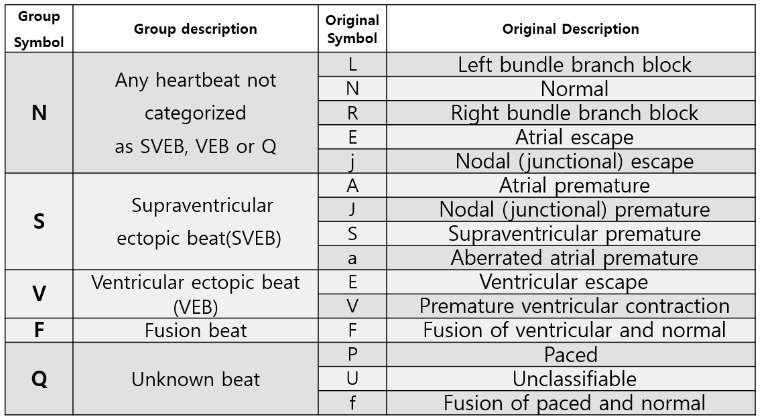  


---

## Build Your Model

### Data preprocessing

In [1]:
import torch
import torchvision
import torchmetrics
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from pathlib import Path
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

In [2]:
#data를 불러오기 위한 path 지정 및 train, test에 대한 DataFrame 생성
drivepath = Path(r'F:/jaeho\SLCL/과제/M3DT/study/Biosignals')
datapath = drivepath / 'mitbih_data_split'

df_train = pd.read_csv(datapath / 'mitbih_train.csv', header = None)
df_test = pd.read_csv(datapath / 'mitbih_test.csv', header = None)
df_train

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [3]:
#train, test dataframe을 ecg data와 label로 구분
y_train = df_train[187].values.reshape(len(df_train[187]), 1)
y_test = df_test[187].values.reshape(len(df_test[187]), 1)

X_train = df_train.iloc[:, :-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1])

X_test = df_test.iloc[:, :-1].values
X_test = X_test.reshape(len(X_test), X_test.shape[1])

#dataset의 형태를 tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_train = y_train.flatten()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
y_test_tensor = y_test_tensor.flatten()

In [4]:
#train data를 train data와 validation data로 split
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train,
    y_train,
    test_size = 0.25,
    random_state = 0,
    shuffle = True,
    stratify = y_train,
)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


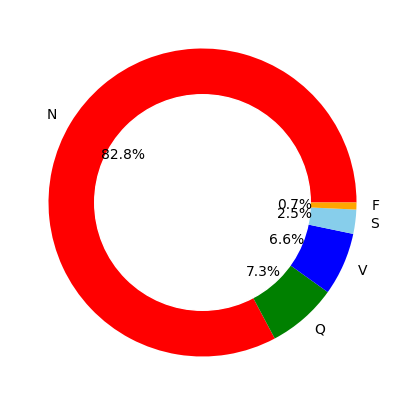

In [5]:
#train data에 대한 class별 data 수 분포 확인
label_count_train = df_train[187].value_counts()
print(label_count_train)

plt.figure(figsize=(10,5))
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(label_count_train, labels=['N','Q','V','S','F'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


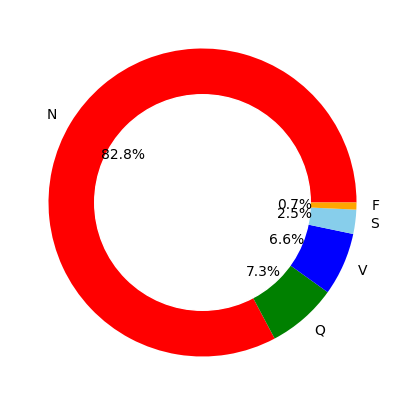

In [6]:
#test data에 대한 class별 data 수 분포 확인
label_count_test = df_test[187].value_counts()
print(label_count_test)

plt.figure(figsize=(10,5))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(label_count_test, labels=['N','Q','V','S','F'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [7]:
#Plot Confusion matrix and score function

class plot_score():
    
    def plot_confusion_matrix(y_true, y_pred):
        classes=['N', 'S', 'V', 'F', 'Q']
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Plot the confusion matrix
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Greens)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=classes,
            yticklabels=classes,
            xlabel='Predicted label',
            ylabel='True label',
            aspect='equal',
            )
        plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
        plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
        plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
        plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center", fontweight='bold',
                        color="white" if cm[i, j] > cm.max() / 2. else "black")
        fig.tight_layout()
        plt.show()
        
    def score_train(y_true, y_pred):
        accuracy_train = accuracy_score(y_true, y_pred)*100
        precision_train = precision_score(y_true, y_pred, average='macro')*100
        recall_train = recall_score(y_true, y_pred, average='macro')*100
        f1_train = f1_score(y_true, y_pred, average='macro')*100
        print("Accuracy (Train): {:.4f}".format(accuracy_train))
        print("Precision (Train): {:.4f}".format(precision_train))
        print("Recall (Train): {:.4f}".format(recall_train))
        print("F1 score (Train): {:.4f}".format(f1_train))
        return accuracy_train, precision_train, recall_train, f1_train
    
    def score_val(y_true, y_pred):
        accuracy_val = accuracy_score(y_true, y_pred)*100
        precision_val = precision_score(y_true, y_pred, average='macro')*100
        recall_val = recall_score(y_true, y_pred, average='macro')*100
        f1_val = f1_score(y_true, y_pred, average='macro')*100
        print("Accuracy (Validation): {:.4f}".format(accuracy_val))
        print("Precision (Validation): {:.4f}".format(precision_val))
        print("Recall (Validation): {:.4f}".format(recall_val))
        print("F1 score (Validation): {:.4f}".format(f1_val))
        return accuracy_val, precision_val, recall_val, f1_val
        
    def score_test(y_true, y_pred):
        accuracy_test = accuracy_score(y_true, y_pred)*100
        precision_test = precision_score(y_true, y_pred, average='macro')*100
        recall_test = recall_score(y_true, y_pred, average='macro')*100
        f1_test = f1_score(y_true, y_pred, average='macro')*100
        print("Accuracy (Test): {:.4f}".format(accuracy_test))
        print("Precision (Test): {:.4f}".format(precision_test))
        print("Recall (Test): {:.4f}".format(recall_test))
        print("F1 score (Test): {:.4f}".format(f1_test))
        return accuracy_test, precision_test, recall_test, f1_test

### Model Construction

In [8]:
# Support Vector Machine

svm = SVC(C=1.0, kernel='rbf', gamma='scale')


# Logistic Regression

lr = LogisticRegression(fit_intercept=True, solver='lbfgs', random_state=0)


# Decision Tree

dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20, random_state=0)


# Linear Neural Network

hidden_nn = nn.Linear(187, 300, bias=True)
output_nn = nn.Linear(300, 5, bias=True)

model_nn = nn.Sequential(hidden_nn, output_nn)
loss_fn_nn = nn.CrossEntropyLoss()
optimizer_nn = optim.SGD(model_nn.parameters(), lr=0.01)


# Non-Linear Neural Network

hidden_mlp = nn.Linear(187, 300, bias=True)
activation_mlp = nn.ReLU()
output_mlp = nn.Linear(300, 5, bias=True)

model_mlp = nn.Sequential(hidden_mlp, activation_mlp, output_mlp)
loss_fn_mlp = nn.CrossEntropyLoss(reduction = 'sum')
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01)


# Covolutional Neural Network (1d)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*42, 100),
            nn.ReLU(),
            nn.Linear(100, 5)
        )       
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*42)
        out = self.fc_layer(out)

        return out

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_cnn = CNN().to(device)

loss_fn_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=0.01)

### Train Model & Select Model

##### SVM

In [9]:
# fit the model on the training data
start_time = time.time()
svm.fit(X_train, y_train)
training_time_svm = time.time() - start_time
y_pred_svm_train = svm.predict(X_train)

# make predictions on the test data
start_time = time.time()
y_pred_svm_test = svm.predict(X_test)
testing_time_svm = time.time() - start_time

##### Logistic Regression

In [10]:
# fit the model on the training data
start_time = time.time()
lr.fit(X_train, y_train)
training_time_lr = time.time() - start_time
y_pred_lr_train = lr.predict(X_train)

# make predictions on the test data
start_time = time.time()
y_pred_lr_test = lr.predict(X_test)
testing_time_lr = time.time() - start_time

g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Decision Tree

In [11]:
# fit the model on the training data
start_time = time.time()
dt.fit(X_train, y_train)
training_time_dt = time.time() - start_time
y_pred_dt_train = dt.predict(X_train)

# make predictions on the test data
start_time = time.time()
y_pred_dt_test = dt.predict(X_test)
testing_time_dt = time.time() - start_time

##### Linear NN

In [12]:
history_nn = []

start_time = time.time()
for step in tqdm(range(300)):
    y_pred_nn_train = model_nn(X_train_tensor)
    train_loss = loss_fn_nn(y_pred_nn_train, y_train_tensor)
    
    optimizer_nn.zero_grad()
    train_loss.backward()
    optimizer_nn.step()

    model_nn.eval()
    with torch.no_grad():
        y_pred_nn_val = model_nn(X_val_tensor)
        val_loss = loss_fn_nn(y_pred_nn_val, y_val_tensor)
    history_nn.append({"step": step, "train_loss": train_loss.item(), "eval_loss": val_loss.item()})
training_time_nn = time.time() - start_time

  0%|          | 0/300 [00:00<?, ?it/s]

In [13]:
start_time = time.time()
with torch.no_grad():
    y_pred_nn_test = model_nn(X_test_tensor)
    test_loss = loss_fn_nn(y_pred_nn_test, y_test_tensor)
testing_time_nn = time.time() - start_time

print(test_loss.item())

0.6307146549224854


<Axes: xlabel='step'>

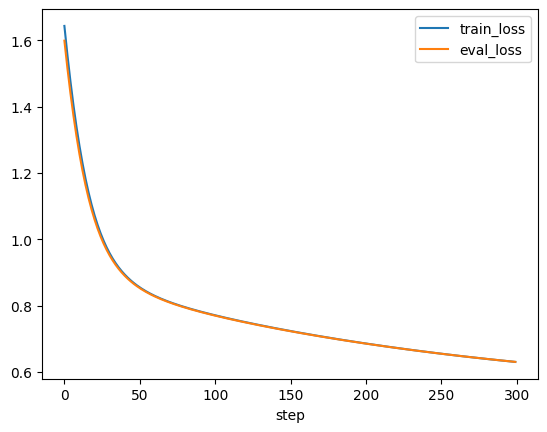

In [14]:
pd.DataFrame(history_nn).plot(x='step', y=['train_loss', 'eval_loss'])

##### Non-Linear NN

In [15]:
history_mlp = []

start_time = time.time()
for step in tqdm(range(300)):
    y_pred_mlp_train = model_mlp(X_train_tensor)
    train_loss = loss_fn_mlp(y_pred_mlp_train, y_train_tensor)
    
    optimizer_mlp.zero_grad()
    train_loss.backward()
    optimizer_mlp.step()

    model_mlp.eval()
    with torch.no_grad():
        y_pred_mlp_val = model_mlp(X_val_tensor)
        val_loss = loss_fn_mlp(y_pred_mlp_val, y_val_tensor)
    history_mlp.append({"step": step, "train_loss": train_loss.item(), "eval_loss": val_loss.item()})
training_time_mlp = time.time() - start_time

  0%|          | 0/300 [00:00<?, ?it/s]

In [16]:
start_time = time.time()
with torch.no_grad():
    y_pred_mlp_test = model_mlp(X_test_tensor)
    test_loss = loss_fn_mlp(y_pred_mlp_test, y_test_tensor)
testing_time_mlp = time.time() - start_time

print(test_loss.item())

3674028.0


<Axes: xlabel='step'>

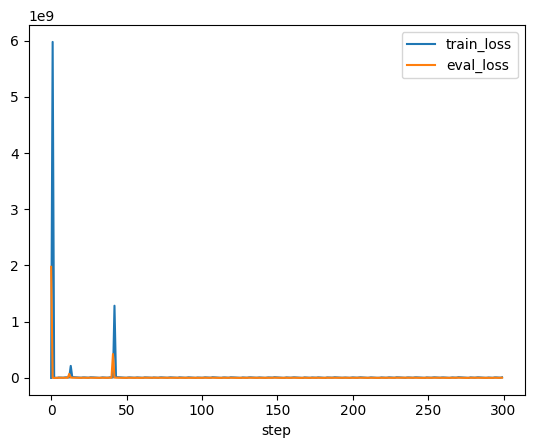

In [17]:
pd.DataFrame(history_mlp).plot(x='step', y=['train_loss', 'eval_loss'])

In [18]:
# Batch training
num_epoch = 300
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

history_mlp2 = []

start_time = time.time()
for epoch in tqdm(range(num_epoch)):
    
    train_loss = 0.0
    eval_loss = 0.0
    
    model_mlp.train()
    for batch in train_loader:
        x, y_true = batch
        y_logits_train = model_mlp(x)
        
        loss = loss_fn_mlp(y_logits_train, y_true)
        train_loss += loss
        
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_mlp.step()
        
    train_loss /= len(train_dataset)

    model_mlp.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, y_true = batch
            y_logits_val = model_mlp(x)

            loss = loss_fn_mlp(y_logits_val, y_true)
            eval_loss += loss
            
    eval_loss /= len(val_dataset)
    
    history_mlp2.append({
        'epoch': epoch,
        'train_loss': train_loss.item(),
        'eval_loss': eval_loss.item(),
    })
training_time_mlp2 = time.time() - start_time

  0%|          | 0/300 [00:00<?, ?it/s]

In [19]:
test_loss = 0.0

with torch.no_grad():
    start_time = time.time()
    for batch in test_loader:
        x, y_true = batch
        y_logits_test = model_mlp(x)
        loss = loss_fn_mlp(y_logits_test, y_true)
        test_loss += loss
    testing_time_mlp2 = time.time() - start_time
test_loss /= len(test_dataset)

print(test_loss.item())

0.6577945351600647


<Axes: xlabel='epoch'>

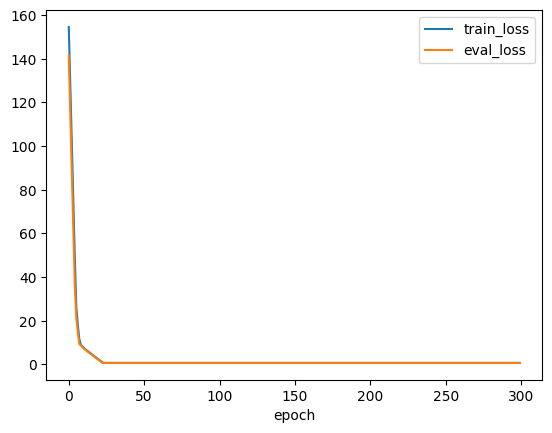

In [20]:
pd.DataFrame(history_mlp2).plot(x='epoch', y=['train_loss', 'eval_loss'])

In [21]:
with torch.no_grad():
    y_pred_mlp2_train = model_mlp(X_train_tensor)
    y_pred_mlp2_val = model_mlp(X_val_tensor)
    y_pred_mlp2_test = model_mlp(X_test_tensor)

##### CNN

In [22]:
num_epoch = 50
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

history_cnn = []

start_time = time.time()
for epoch in tqdm(range(num_epoch)):
    
    train_loss = 0.0
    eval_loss = 0.0
    
    model_cnn.train()
    for batch in train_loader:
        x, y_true = batch
        x=x.unsqueeze(1)
        y_logits_train = model_cnn(x)
        
        loss = loss_fn_cnn(y_logits_train, y_true)
        train_loss += loss
        
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()
        
    train_loss /= len(train_dataset)

    model_cnn.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, y_true = batch
            x=x.unsqueeze(1)
            y_logits_val = model_cnn(x)

            loss = loss_fn_cnn(y_logits_val, y_true)
            eval_loss += loss
            
    eval_loss /= len(val_dataset)
    
    history_cnn.append({
        'epoch': epoch,
        'train_loss': train_loss.item(),
        'eval_loss': eval_loss.item(),
    })
training_time_cnn = time.time() - start_time

  0%|          | 0/50 [00:00<?, ?it/s]

In [23]:
test_loss = 0.0

with torch.no_grad():
    start_time = time.time()
    for batch in test_loader:
        x, y_true = batch
        x=x.unsqueeze(1)
        y_logits_test = model_cnn(x)
        loss = loss_fn_cnn(y_logits_test, y_true)
        test_loss += loss
    testing_time_cnn = time.time() - start_time
test_loss /= len(test_dataset)

print(test_loss.item())

0.0010633297497406602


<Axes: xlabel='epoch'>

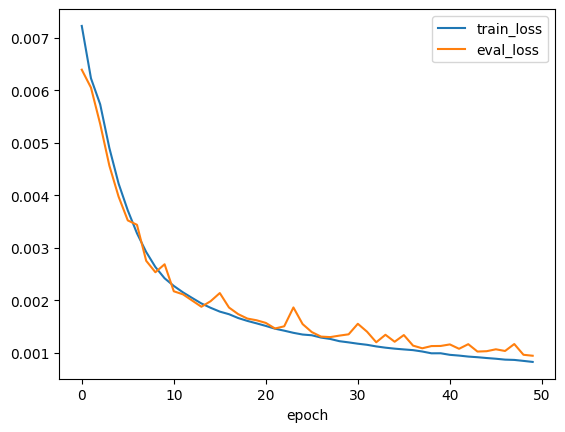

In [24]:
pd.DataFrame(history_cnn).plot(x='epoch', y=['train_loss', 'eval_loss'])

In [25]:
with torch.no_grad():
    y_pred_cnn_train = model_cnn(X_train_tensor.unsqueeze(1))
    y_pred_cnn_val = model_cnn(X_val_tensor.unsqueeze(1))
    y_pred_cnn_test = model_cnn(X_test_tensor.unsqueeze(1))

---

## Performance

##### SVM

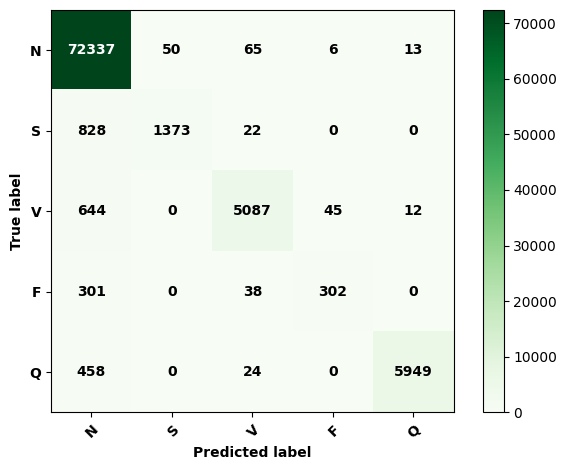

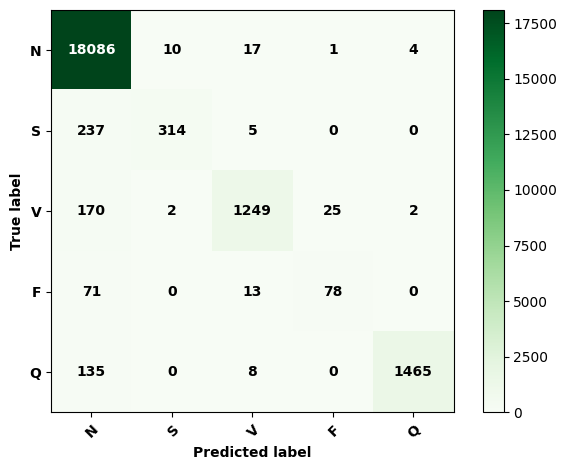

Accuracy (Train): 97.1378
Precision (Train): 95.1565
Recall (Train): 77.8172
F1 score (Train): 84.5348
Accuracy (Test): 96.8025
Precision (Test): 92.8609
Recall (Test): 76.3620
F1 score (Test): 82.8850


In [26]:
plot_score.plot_confusion_matrix(y_train, y_pred_svm_train)
plot_score.plot_confusion_matrix(y_test, y_pred_svm_test)
accuracy_svm_train, precision_svm_train, recall_svm_train, f1_svm_train = plot_score.score_train(y_train, y_pred_svm_train)
accuracy_svm_test, precision_svm_test, recall_svm_test, f1_svm_test = plot_score.score_test(y_test, y_pred_svm_test)

##### Logistic Regression

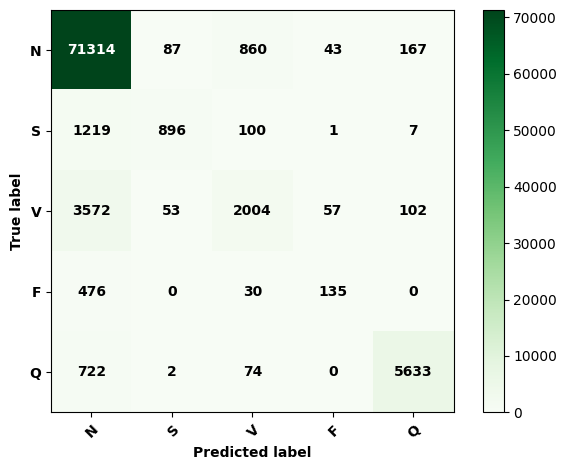

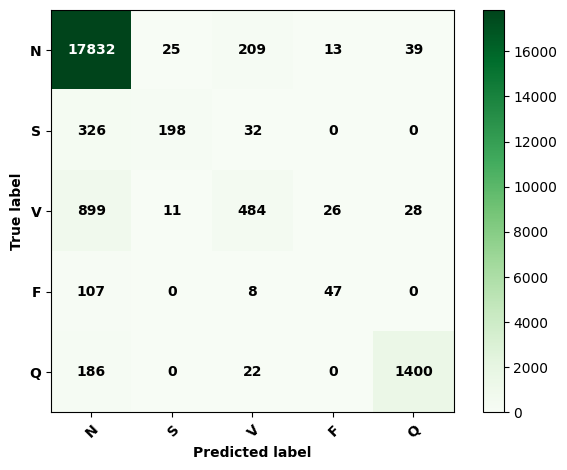

Accuracy (Train): 91.3516
Precision (Train): 79.2849
Recall (Train): 56.3970
F1 score (Train): 63.5044
Accuracy (Test): 91.1794
Precision (Test): 78.1921
Recall (Test): 56.7071
F1 score (Test): 63.6424


In [27]:
plot_score.plot_confusion_matrix(y_train, y_pred_lr_train)
plot_score.plot_confusion_matrix(y_test, y_pred_lr_test)
accuracy_lr_train, precision_lr_train, recall_lr_train, f1_lr_train = plot_score.score_train(y_train, y_pred_lr_train)
accuracy_lr_test, precision_lr_test, recall_lr_test, f1_lr_test = plot_score.score_test(y_test, y_pred_lr_test)

##### Decision Tree

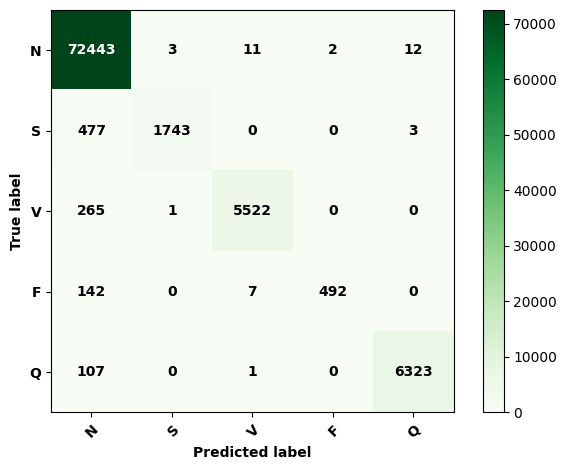

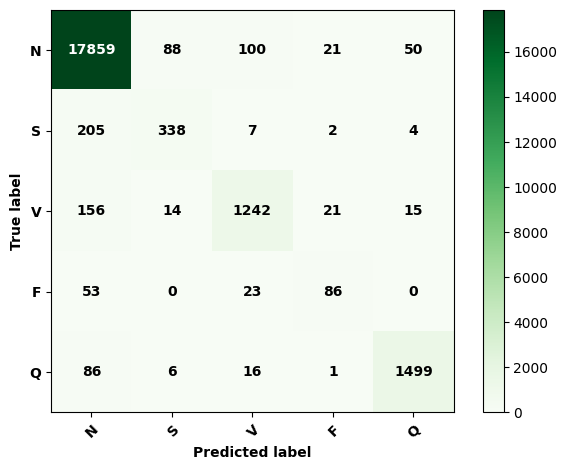

Accuracy (Train): 98.8224
Precision (Train): 99.4874
Recall (Train): 89.7698
F1 score (Train): 94.0655
Accuracy (Test): 96.0351
Precision (Test): 84.7582
Recall (Test): 78.2886
F1 score (Test): 81.2142


In [28]:
plot_score.plot_confusion_matrix(y_train, y_pred_dt_train)
plot_score.plot_confusion_matrix(y_test, y_pred_dt_test)
accuracy_dt_train, precision_dt_train, recall_dt_train, f1_dt_train = plot_score.score_train(y_train, y_pred_dt_train)
accuracy_dt_test, precision_dt_test, recall_dt_test, f1_dt_test = plot_score.score_test(y_test, y_pred_dt_test)

##### Linear NN

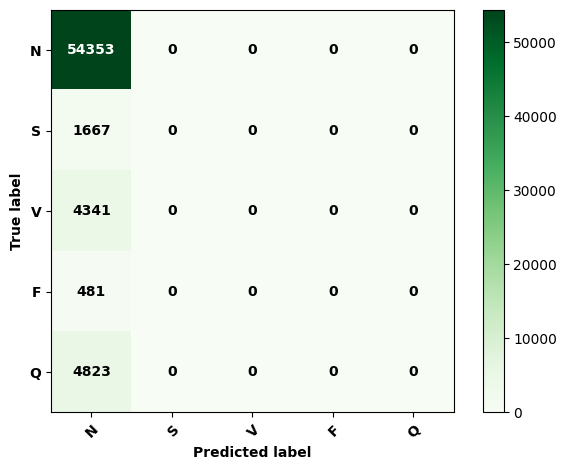

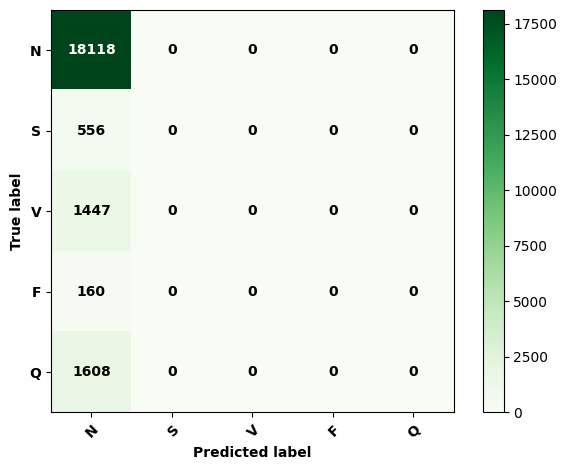

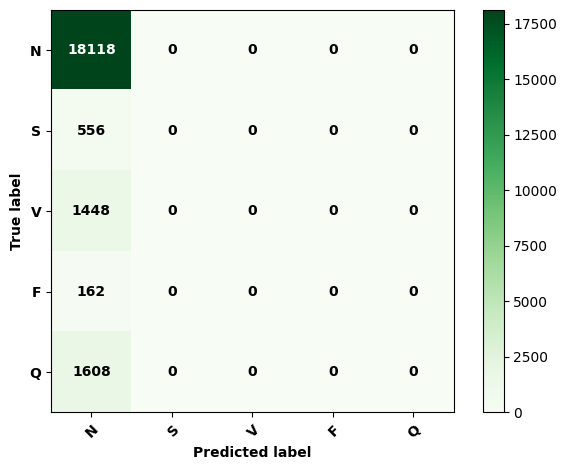

Accuracy (Train): 82.7732
Precision (Train): 16.5546
Recall (Train): 20.0000
F1 score (Train): 18.1149
Accuracy (Validation): 82.7722
Precision (Validation): 16.5544
Recall (Validation): 20.0000
F1 score (Validation): 18.1148
Accuracy (Test): 82.7608
Precision (Test): 16.5522
Recall (Test): 20.0000
F1 score (Test): 18.1135


g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
plot_score.plot_confusion_matrix(y_train_tensor, y_pred_nn_train.argmax(dim=1))
plot_score.plot_confusion_matrix(y_val_tensor, y_pred_nn_val.argmax(dim=1))
plot_score.plot_confusion_matrix(y_test_tensor, y_pred_nn_test.argmax(dim=1))
accuracy_nn_train, precision_nn_train, recall_nn_train, f1_nn_train = plot_score.score_train(y_train_tensor, y_pred_nn_train.detach().numpy().argmax(axis=1))
accuracy_nn_val, precision_nn_val, recall_nn_val, f1_nn_val = plot_score.score_val(y_val_tensor, y_pred_nn_val.detach().numpy().argmax(axis=1))
accuracy_nn_test, precision_nn_test, recall_nn_test, f1_nn_test = plot_score.score_test(y_test_tensor, y_pred_nn_test.detach().numpy().argmax(axis=1))

##### Non-Linear NN

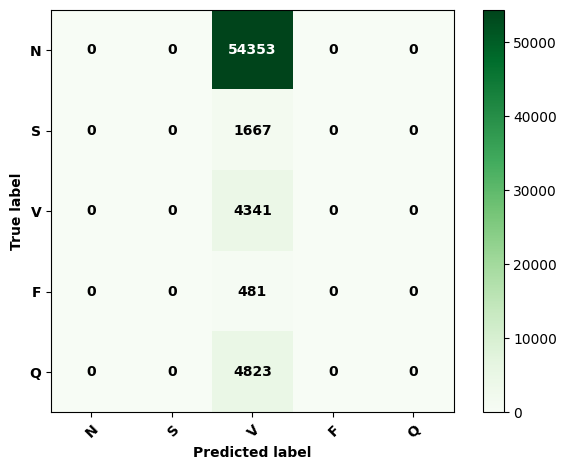

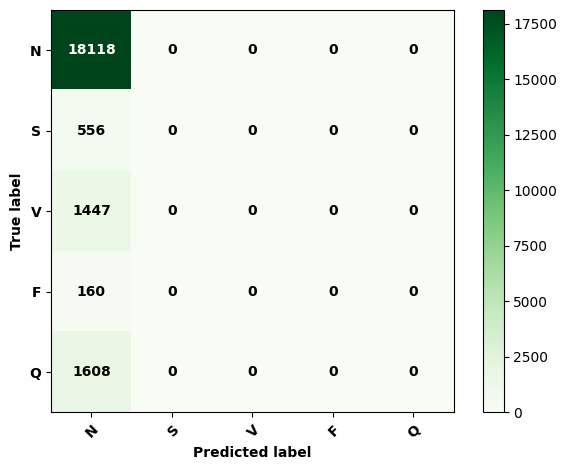

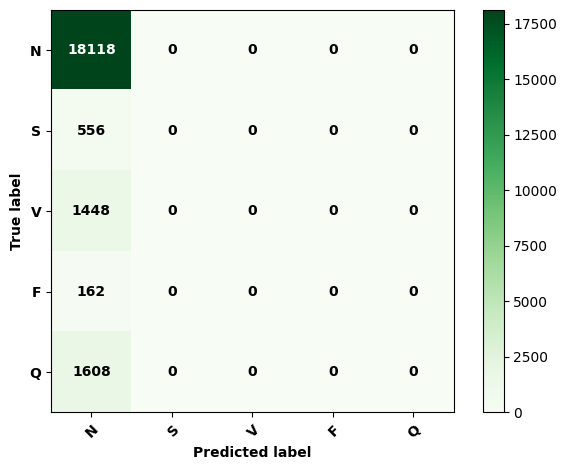

Accuracy (Train): 6.6108
Precision (Train): 1.3222
Recall (Train): 20.0000
F1 score (Train): 2.4804
Accuracy (Validation): 82.7722
Precision (Validation): 16.5544
Recall (Validation): 20.0000
F1 score (Validation): 18.1148
Accuracy (Test): 82.7608
Precision (Test): 16.5522
Recall (Test): 20.0000
F1 score (Test): 18.1135


g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
plot_score.plot_confusion_matrix(y_train_tensor, y_pred_mlp_train.argmax(dim=1))
plot_score.plot_confusion_matrix(y_val_tensor, y_pred_mlp_val.argmax(dim=1))
plot_score.plot_confusion_matrix(y_test_tensor, y_pred_mlp_test.argmax(dim=1))
accuracy_mlp_train, precision_mlp_train, recall_mlp_train, f1_mlp_train = plot_score.score_train(y_train_tensor, y_pred_mlp_train.detach().numpy().argmax(axis=1))
accuracy_mlp_val, precision_mlp_val, recall_mlp_val, f1_mlp_val = plot_score.score_val(y_val_tensor, y_pred_mlp_val.detach().numpy().argmax(axis=1))
accuracy_mlp_test, precision_mlp_test, recall_mlp_test, f1_mlp_test = plot_score.score_test(y_test_tensor, y_pred_mlp_test.detach().numpy().argmax(axis=1))

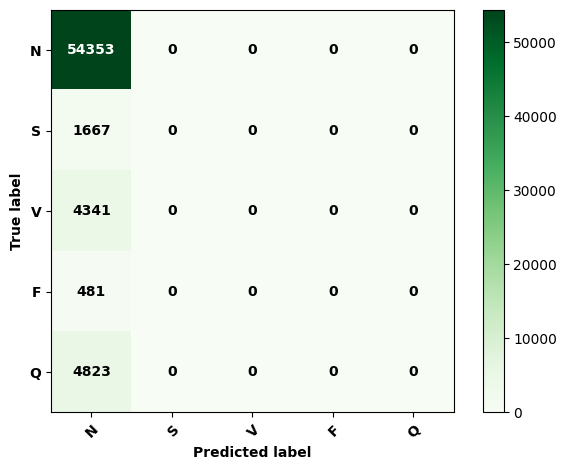

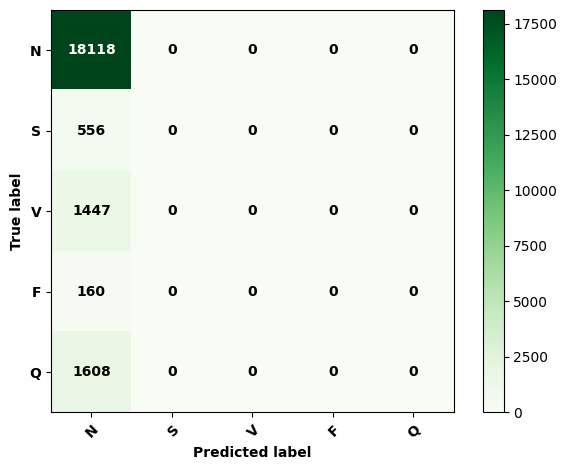

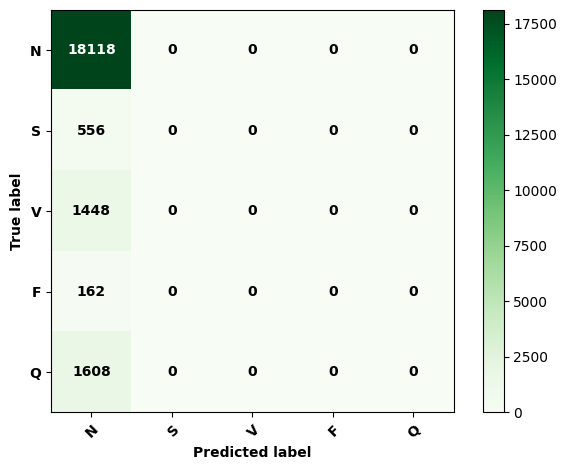

Accuracy (Train): 82.7732
Precision (Train): 16.5546
Recall (Train): 20.0000
F1 score (Train): 18.1149
Accuracy (Validation): 82.7722
Precision (Validation): 16.5544
Recall (Validation): 20.0000
F1 score (Validation): 18.1148
Accuracy (Test): 82.7608
Precision (Test): 16.5522
Recall (Test): 20.0000
F1 score (Test): 18.1135


g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
g:\내 드라이브\재호\수업\2023-2 (1학기)\ML and DL\DGU-MLDL\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
plot_score.plot_confusion_matrix(y_train_tensor, y_pred_mlp2_train.argmax(dim=1))
plot_score.plot_confusion_matrix(y_val_tensor, y_pred_mlp2_val.argmax(dim=1))
plot_score.plot_confusion_matrix(y_test_tensor, y_pred_mlp2_test.argmax(dim=1))
accuracy_mlp2_train, precision_mlp2_train, recall_mlp2_train, f1_mlp2_train = plot_score.score_train(y_train_tensor, y_pred_mlp2_train.detach().numpy().argmax(axis=1))
accuracy_mlp2_val, precision_mlp2_val, recall_mlp2_val, f1_mlp2_val = plot_score.score_val(y_val_tensor, y_pred_mlp2_val.detach().numpy().argmax(axis=1))
accuracy_mlp2_test, precision_mlp2_test, recall_mlp2_test, f1_mlp2_test = plot_score.score_test(y_test_tensor, y_pred_mlp2_test.detach().numpy().argmax(axis=1))

##### CNN

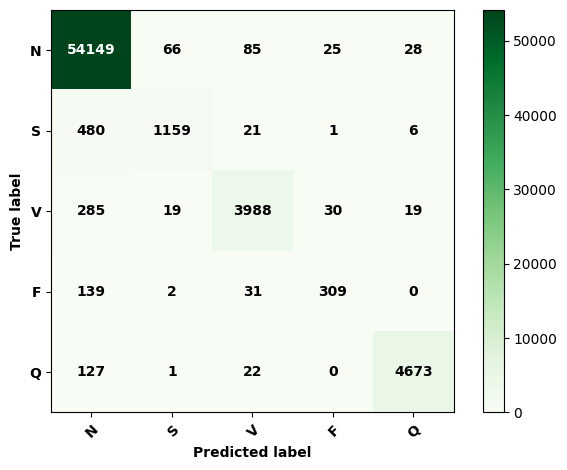

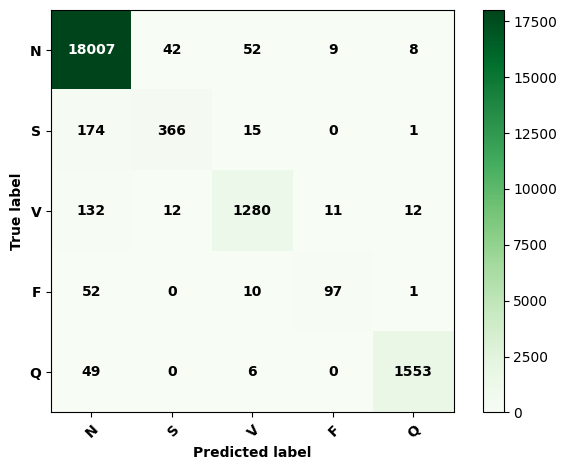

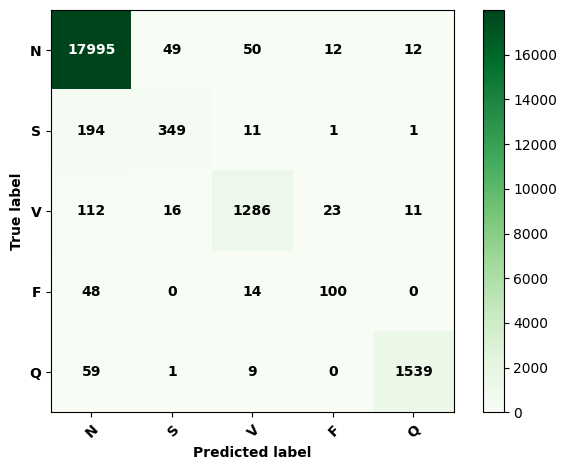

Accuracy (Train): 97.8878
Precision (Train): 94.1553
Recall (Train): 84.4300
F1 score (Train): 88.6622
Accuracy (Validation): 97.3229
Precision (Validation): 92.0704
Recall (Validation): 82.1756
F1 score (Validation): 86.4605
Accuracy (Test): 97.1542
Precision (Test): 89.5431
Recall (Test): 81.6681
F1 score (Test): 85.1738


In [32]:
plot_score.plot_confusion_matrix(y_train_tensor, y_pred_cnn_train.argmax(dim=1))
plot_score.plot_confusion_matrix(y_val_tensor, y_pred_cnn_val.argmax(dim=1))
plot_score.plot_confusion_matrix(y_test_tensor, y_pred_cnn_test.argmax(dim=1))
accuracy_cnn_train, precision_cnn_train, recall_cnn_train, f1_cnn_train = plot_score.score_train(y_train_tensor, y_pred_cnn_train.detach().numpy().argmax(axis=1))
accuracy_cnn_val, precision_cnn_val, recall_cnn_val, f1_cnn_val = plot_score.score_val(y_val_tensor, y_pred_cnn_val.detach().numpy().argmax(axis=1))
accuracy_cnn_test, precision_cnn_test, recall_cnn_test, f1_cnn_test = plot_score.score_test(y_test_tensor, y_pred_cnn_test.detach().numpy().argmax(axis=1))

In [33]:
all_model = pd.DataFrame(columns=['Model', 'Accuracy (Train)', 'Precision (Train)', 'Recall (Train)', 'F1 Score (Train)', 'Accuracy (Test)', 'Precision (Test)', 'Recall (Test)', 'F1 Score (Test)','Training Time','Testing Time'])
all_model.loc[0] = ['SVM',accuracy_svm_train,precision_svm_train,recall_svm_train,f1_svm_train,accuracy_svm_test,precision_svm_test,recall_svm_test,f1_svm_test,training_time_svm,testing_time_svm]
all_model.loc[1] = ['Logistic Regression',accuracy_lr_train,precision_lr_train,recall_lr_train,f1_lr_train,accuracy_lr_test,precision_lr_test,recall_lr_test,f1_lr_test,training_time_lr,testing_time_lr]
all_model.loc[2] = ['Decision Tree',accuracy_dt_train,precision_dt_train,recall_dt_train,f1_dt_train,accuracy_dt_test,precision_dt_test,recall_dt_test,f1_dt_test,training_time_dt,testing_time_dt]
all_model.loc[3] = ['Neural Network',accuracy_nn_train,precision_nn_train,recall_nn_train,f1_nn_train,accuracy_nn_test,precision_nn_test,recall_nn_test,f1_nn_test,training_time_nn,testing_time_nn]
all_model.loc[4] = ['Non-Linear NN',accuracy_mlp_train,precision_mlp_train,recall_mlp_train,f1_mlp_train,accuracy_mlp_test,precision_mlp_test,recall_mlp_test,f1_mlp_test,training_time_mlp,testing_time_mlp]
all_model.loc[5] = ['Non-Linear NN_batch training',accuracy_mlp2_train,precision_mlp2_train,recall_mlp2_train,f1_mlp2_train,accuracy_mlp2_test,precision_mlp2_test,recall_mlp2_test,f1_mlp2_test,training_time_mlp2,testing_time_mlp2]
all_model.loc[6] = ['CNN',accuracy_cnn_train,precision_cnn_train,recall_cnn_train,f1_cnn_train,accuracy_cnn_test,precision_cnn_test,recall_cnn_test,f1_cnn_test,training_time_cnn,testing_time_cnn]
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time,Testing Time
0,SVM,97.137766,95.156528,77.817231,84.534815,96.802485,92.860942,76.362044,82.885034,101.956028,32.736239
1,Logistic Regression,91.351623,79.284877,56.396990,63.504420,91.179426,78.192081,56.707081,63.642405,2.913340,0.006001
2,Decision Tree,98.822441,99.487420,89.769782,94.065452,96.035081,84.758181,78.288629,81.214199,30.857759,0.012001
3,Neural Network,82.773167,16.554633,20.000000,18.114949,82.760826,16.552165,20.000000,18.113472,36.206803,0.015511
4,Non-Linear NN,6.610828,1.322166,20.000000,2.480359,82.760826,16.552165,20.000000,18.113472,50.195001,0.021000
5,Non-Linear NN_batch training,82.773167,16.554633,20.000000,18.114949,82.760826,16.552165,20.000000,18.113472,249.925416,0.154016
6,CNN,97.887764,94.155323,84.430014,88.662245,97.154212,89.543062,81.668081,85.173775,322.847287,0.737582


## 결과해석
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Model</th>
      <th>Accuracy (Train)</th>
      <th>Precision (Train)</th>
      <th>Recall (Train)</th>
      <th>F1 Score (Train)</th>
      <th>Accuracy (Test)</th>
      <th>Precision (Test)</th>
      <th>Recall (Test)</th>
      <th>F1 Score (Test)</th>
      <th>Training Time</th>
      <th>Testing Time</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>SVM</td>
      <td>97.137766</td>
      <td>95.156528</td>
      <td>77.817231</td>
      <td>84.534815</td>
      <td>96.802485</td>
      <td>92.860942</td>
      <td>76.362044</td>
      <td>82.885034</td>
      <td>101.956028</td>
      <td>32.736239</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Logistic Regression</td>
      <td>91.351623</td>
      <td>79.284877</td>
      <td>56.396990</td>
      <td>63.504420</td>
      <td>91.179426</td>
      <td>78.192081</td>
      <td>56.707081</td>
      <td>63.642405</td>
      <td>2.913340</td>
      <td>0.006001</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Decision Tree</td>
      <td>98.822441</td>
      <td>99.487420</td>
      <td>89.769782</td>
      <td>94.065452</td>
      <td>96.035081</td>
      <td>84.758181</td>
      <td>78.288629</td>
      <td>81.214199</td>
      <td>30.857759</td>
      <td>0.012001</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Neural Network</td>
      <td>82.773167</td>
      <td>16.554633</td>
      <td>20.000000</td>
      <td>18.114949</td>
      <td>82.760826</td>
      <td>16.552165</td>
      <td>20.000000</td>
      <td>18.113472</td>
      <td>36.206803</td>
      <td>0.015511</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Non-Linear NN</td>
      <td>6.610828</td>
      <td>1.322166</td>
      <td>20.000000</td>
      <td>2.480359</td>
      <td>82.760826</td>
      <td>16.552165</td>
      <td>20.000000</td>
      <td>18.113472</td>
      <td>50.195001</td>
      <td>0.021000</td>
    </tr>
    <tr>
      <th>5</th>
      <td>Non-Linear NN_batch training</td>
      <td>82.773167</td>
      <td>16.554633</td>
      <td>20.000000</td>
      <td>18.114949</td>
      <td>82.760826</td>
      <td>16.552165</td>
      <td>20.000000</td>
      <td>18.113472</td>
      <td>249.925416</td>
      <td>0.154016</td>
    </tr>
    <tr>
      <th>6</th>
      <td>CNN</td>
      <td>97.887764</td>
      <td>94.155323</td>
      <td>84.430014</td>
      <td>88.662245</td>
      <td>97.154212</td>
      <td>89.543062</td>
      <td>81.668081</td>
      <td>85.173775</td>
      <td>322.847287</td>
      <td>0.737582</td>
    </tr>
  </tbody>
</table>
</div>

Conv1d CNN 모델의 accuracy, f1 score가 가장 좋게 나타남  
Linear NN, Non-Linear NN의 경우 예측값이 가장 데이터 갯수가 많은 class로만 나타나서 정확한 성능을 확인하기 어려움  
data sample 수를 조정한 후 다시 학습 및 테스트를 거쳐 성능을 확인해볼 수 있을 것으로 판단됨

### *추후 진행 계획 : preprocessing of Raw_data
- Midterm Project에는 preprocessed MIT-BIH Arrhythmia dataset을 사용
- Physionet에서 MIT-BIH Arrhythmia dataset 다운로드가 가능
- Midterm proj에 사용된 dataset과 같이 가공하기 위해서 다음과 같은 과정들이 요구됨
  - Filtering
  - Slicing
  - Normalization  
- Raw data를 전처리하여 Midterm proj에서 구성한 모델들에 학습시키는 것이 최종 목표
- 현재 진행된 상황과 어려운 부분 기록함.

In [34]:
#data, annotation 파일을 불러오기 위한 path 지정 및 데이터파일명, annotations 파일명 리스트 생성
raw_datapath = drivepath / 'mitbih_database'
records = sorted(raw_datapath.glob('*.csv'))
annotations = sorted(raw_datapath.glob('*.txt'))

In [35]:
# record 파일의 크기는 모두 650000*3
for record in records:
    df = pd.read_csv(os.path.join(datapath, record))
    if df.shape != (650000, 3):
        print(f"{record} : {df.shape}")

In [36]:
##annotations 통합 DataFrame 생성
rows = []

for annotation in tqdm(annotations):
    with annotation.open() as f:
        for i, line in enumerate(f):
            if i >= 1:
                line = line.strip()
                if not line:
                    continue
            
                args = line.split()
                time = str(args[0])
                sample = float(args[1])
                type = str(args[2])
                for i in time:
                    args_time = time.split(':')
                    time_min = int(args_time[0])
                    time_sec = float(args_time[1])

                rows.append((annotation.stem[:3], time_min, time_sec, sample, type))

  0%|          | 0/48 [00:00<?, ?it/s]

In [37]:
#label 종류 및 개수 확인
df_annotation = pd.DataFrame(rows, columns=['Patient', 'Time_min', 'Time_sec', 'Sample', 'Type'])
type_count = df_annotation['Type'].value_counts()
print(type_count)

Type
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: count, dtype: int64


### Symbol	Meaning
- · or N : Normal beat
- L	: Left bundle branch block beat
- R	: Right bundle branch block beat
- A	: Atrial premature beat
- a	: Aberrated atrial premature beat
- J	: Nodal (junctional) premature beat
- S	: Supraventricular premature beat
- V	: Premature ventricular contraction
- F	: Fusion of ventricular and normal beat
- [	: Start of ventricular flutter/fibrillation
- !	: Ventricular flutter wave
- ]	: End of ventricular flutter/fibrillation
- e	: Atrial escape beat
- j	: Nodal (junctional) escape beat
- E	: Ventricular escape beat
- /	: Paced beat
- f	: Fusion of paced and normal beat
- x	: Non-conducted P-wave (blocked APB)
- Q	: Unclassifiable beat
- |	: Isolated QRS-like artifact

### Rhythm annotations appear below the level used for beat annotations:
- (AB	: Atrial bigeminy
- (AFIB	: Atrial fibrillation
- (AFL	: Atrial flutter
- (B	: Ventricular bigeminy
- (BII	: 2° heart block
- (IVR	: Idioventricular rhythm
- (N	: Normal sinus rhythm
- (NOD	: Nodal (A-V junctional) rhythm
- (P	: Paced rhythm
- (PREX	: Pre-excitation (WPW)
- (SBR	: Sinus bradycardia
- (SVTA	: Supraventricular tachyarrhythmia
- (T	: Ventricular trigeminy
- (VFL	: Ventricular flutter
- (VT	: Ventricular tachycardia

### Signal quality and comment annotations appear above the level used for beat annotations:
- qq : Signal quality change: the first character ('c' or `n') indicates the quality of the upper signal (clean or noisy), and the second character indicates the quality of the lower signal
- U	: Extreme noise or signal loss in both signals: ECG is unreadable
- M : (or MISSB)	Missed beat
- P : (or PSE)	Pause
- T : (or TS)	Tape slippage

In [38]:
#AAMI 분류는 MIT-BIH Arrhythmia dataset의 annotation type들을 5개로 분류
AAMI_N = ['L', 'N', 'R', 'e', 'j']
AAMI_S = ['A', 'J', 'S', 'a']
AAMI_V = ['E', 'V']
AAMI_F = ['F']
AAMI_Q = ['P', 'U', 'f']

AAMI_mapping = {label : 'N' for label in AAMI_N}
AAMI_mapping.update({label : 'S' for label in AAMI_S})
AAMI_mapping.update({label : 'V' for label in AAMI_V})
AAMI_mapping.update({label : 'F' for label in AAMI_F})
AAMI_mapping.update({label : 'Q' for label in AAMI_Q})

df_annotation_AAMI = df_annotation.replace({'Type' : AAMI_mapping})
df_annotation_AAMI = df_annotation_AAMI[df_annotation_AAMI['Type'].isin(list(set(AAMI_mapping.values())))]
df_annotation_AAMI

,Patient,Time_min,Time_sec,Sample,Type
1,100,0,0.214,77.0,N
2,100,0,1.028,370.0,N
3,100,0,1.839,662.0,N
4,100,0,2.628,946.0,N
5,100,0,3.419,1231.0,N
...,...,...,...,...,...
112642,234,30,2.214,648797.0,N
112643,234,30,2.889,649040.0,N
112644,234,30,3.589,649292.0,N
112645,234,30,4.267,649536.0,N


In [39]:
type_count_AAMI = df_annotation_AAMI['Type'].value_counts()
print(type_count_AAMI)

Type
N    90631
V     7236
S     2781
Q     1015
F      803
Name: count, dtype: int64


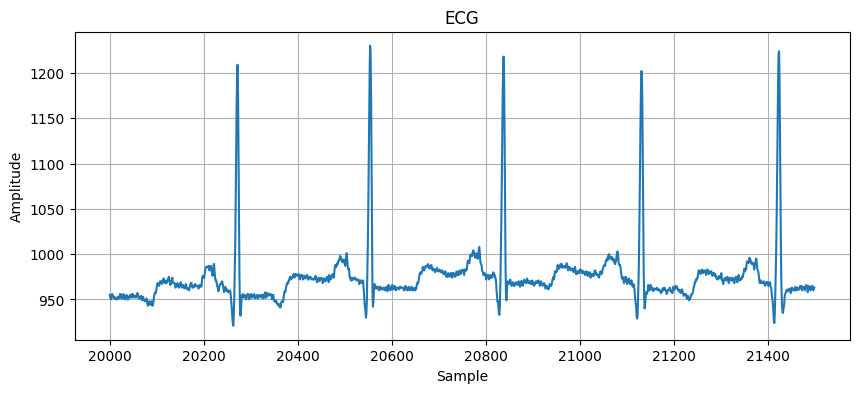

In [40]:
#record 파일 중 100.csv의 lead2 데이터 visualization
data = pd.read_csv(raw_datapath / '100.csv')
lead2 = data['\'MLII\'']

plt.figure(figsize = (10, 4))
plt.plot(lead2[20000:21500])
plt.title('ECG')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

- Midterm proj에서 사용한 preprocessed data는 ECG의 한 cycle에 대해  
    - 시작점 : 직전 R-peak  
    - 끝점 : S-wave가 끝나는 지점
- QRS complex 구간 검출 algorithm을 이용하여 S끝점을 찾아보고자 함
- 'Pan-Tompkins algorithm' : QRS complex 구간 검출에 가장 많이 사용되는 알고리즘

In [41]:
class Pan_Tompkins_QRS():
    def band_pass_filter(self, signal):
        
        # Initialize result
        result = None
        
        # Create a copy of the input signal
        sig = signal.copy()
        
        # Apply the low pass filter using the equation given
        for index in range(len(signal)):
            sig[index] = signal[index]
            
            if (index >= 1):
                sig[index] += 2*sig[index-1]
                
            if (index >= 2):
                sig[index] -= sig[index-2]
                
            if (index >= 6):
                sig[index] -= 2*signal[index-6]
                
            if (index >= 12):
                sig[index] += signal[index-12]
                
        # Copy the result of the low pass filter
        result = sig.copy()
        
        # Apply the high pass filter using the equation given
        for index in range(len(signal)):
            result[index] = -1*sig[index]
            
            if (index >= 1):
                result[index] -= result[index-1]
                
            if (index >= 16):
                result[index] += 32*sig[index-16]
                
            if (index >= 32):
                result[index] += sig[index-32]
                
        # Normalize the result from the high pass filter
        max_val = max(max(result), -min(result))
        result = result/max_val
        
        return result
    
    def derivative(self, signal):
        # Initialize result
        result = signal.copy()

        # Apply the derivative filter using the equation given
        for index in range(len(signal)):
            result[index] = 0

            if (index >= 1):
                result[index] -= 2*signal[index-1]

            if (index >= 2):
                result[index] -= signal[index-2]

            if (index >= 2 and index <= len(signal)-2):
                result[index] += 2*signal[index+1]

            if (index >= 2 and index <= len(signal)-3):
                result[index] += signal[index+2]

            result[index] = (result[index]*360)/8 #MIT-BIH Arrhythmia Databse의 fs = 360Hz

        return result
    
    def squaring(self, signal):
        # Initialize result
        result = signal.copy()

        # Apply the squaring using the equation given
        for index in range(len(signal)):
            result[index] = signal[index]**2

        return result
    
    def moving_window_integration(self, signal):
        # Initialize result and window size for integration
        result = signal.copy()
        win_size = round(0.150 * 360) #MIT-BIH Arrhythmia Databse의 fs = 360Hz
        sum = 0

        # Calculate the sum for the first N terms
        for j in range(win_size):
            sum += signal[j]/win_size
            result[j] = sum
        
        # Apply the moving window integration using the equation given
        for index in range(win_size,len(signal)):  
            sum += signal[index]/win_size
            sum -= signal[index-win_size]/win_size
            result[index] = sum

        return result
    
    def solve(self, signal):
        # Convert the input signal into numpy array
        input_signal = signal.to_numpy() if isinstance(signal, pd.Series) else signal.iloc[:,1].to_numpy()

        # Bandpass Filter
        global bpass
        bpass = self.band_pass_filter(input_signal.copy())

        # Derivative Function
        global der
        der = self.derivative(bpass.copy())

        # Squaring Function
        global sqr
        sqr = self.squaring(der.copy())

        # Moving Window Integration Function
        global mwin
        mwin = self.moving_window_integration(sqr.copy())

        return mwin
    
QRS_detector = Pan_Tompkins_QRS()
output_signal = QRS_detector.solve(lead2)

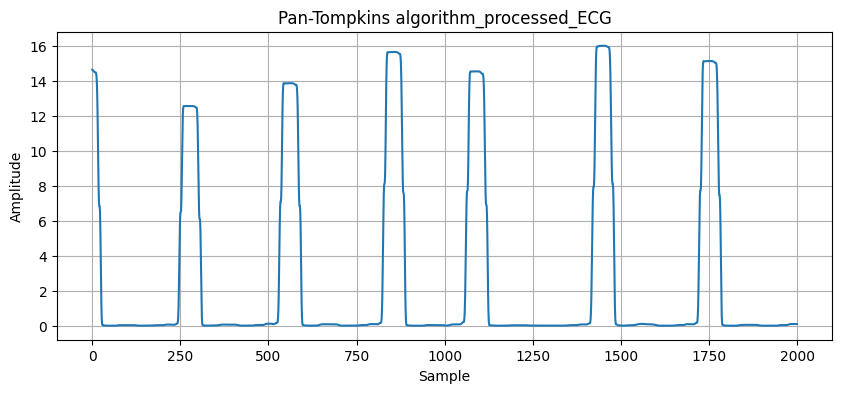

In [42]:
plt.figure(figsize = (10, 4))
plt.plot(output_signal[1000:3000])
plt.title('Pan-Tompkins algorithm_processed_ECG')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [43]:
# Pan-Tompkins algorithm을 거쳐 나온 output_signal plot의 기울기가 급변하는 지점을 이용하여 QRS 구간 검출

annotation_100 = list(df_annotation_AAMI[df_annotation_AAMI['Patient'] == '100'].iloc[:,3])
peaks = [int(samp) for samp in annotation_100]

gradient = np.diff(output_signal)
threshold = np.max(np.abs(gradient)) * 0.01 #threshold값 조정하면서 찾기
sharp_changes = np.where(np.abs(gradient) > threshold)[0]
peak_endings = []

for peak in peaks:
    end_points = sharp_changes[sharp_changes > peak]
    if len(end_points) > 0:
        peak_end = end_points[0]
        peak_endings.append(peak_end)
       
for peak, end in zip(peaks, peak_endings):
    print(f"Peak at position {peak} ends at position {end}")

Peak at position 77 ends at position 393
Peak at position 370 ends at position 393
Peak at position 662 ends at position 678
Peak at position 946 ends at position 970
Peak at position 1231 ends at position 1538
Peak at position 1515 ends at position 1538
Peak at position 1809 ends at position 1832
Peak at position 2044 ends at position 2067
Peak at position 2402 ends at position 2426
Peak at position 2706 ends at position 2729
Peak at position 2998 ends at position 3013
Peak at position 3282 ends at position 3885
Peak at position 3560 ends at position 3885
Peak at position 3862 ends at position 3885
Peak at position 4170 ends at position 5083
Peak at position 4466 ends at position 5083
Peak at position 4764 ends at position 5083
Peak at position 5060 ends at position 5083
Peak at position 5346 ends at position 5657
Peak at position 5633 ends at position 5657
Peak at position 5918 ends at position 5941
Peak at position 6214 ends at position 6229
Peak at position 6527 ends at position 65

In [44]:
# 기울기 급변하는 지점 탐색 방법 오류가 많음
# -> peak 이후로부터 1보다 작아지는 지점과 다시 1보다 커지는 지점 사이에서의 최소값을 peak 오른쪽 부분에서 최소값을 찾는다는 가정

annotation_100 = list(df_annotation_AAMI[df_annotation_AAMI['Patient'] == '100'].iloc[:,3])
peaks = [int(samp) for samp in annotation_100]

valleys = []

for peak in peaks:
    post_peak_data = output_signal[peak:] #peak이후의 데이터 포인트 추출
    try: #peak 이후에 1보다 작아지는 첫 지점 찾기
        start_idx = next(i for i, val in enumerate(post_peak_data) if val < 1)
    except StopIteration: #만약 1보다 작아지는 지점이 없다면, 다음 peak로 넘어감
        continue
    try:
        end_idx = next(i for i, val in enumerate(post_peak_data[start_idx:], start = start_idx) if val > 1)
    except StopIteration:
        end_idx = len(post_peak_data) - 1
        
    interval = post_peak_data[start_idx : end_idx + 1]
    min_val = np.min(interval)
    min_idx = np.argmin(interval) + peak + start_idx
    valleys.append((min_idx, min_val))
    
print(valleys)

[(80, 0.22380388462032552), (370, 0.0969369397340896), (662, 0.10111805546429888), (946, 0.11652993390246756), (1231, 0.05678408913825561), (1515, 0.09502839046627909), (1809, 0.08577850370064072), (2044, 0.08566336896982152), (2402, 0.07192668258617614), (2706, 0.0848520426064767), (3000, 0.09844347167841623), (3284, 0.10764475612660479), (3562, 0.08390671630059561), (3862, 0.0742901032912476), (4170, 0.13186968820993927), (4466, 0.07179985781433364), (4764, 0.07771615241346748), (5060, 0.0844159793074866), (5347, 0.09069908988757337), (5633, 0.10614501592378768), (5919, 0.09669328347778001), (6214, 0.07223233677319056), (6527, 0.08695626769520011), (6823, 0.10358146922019756), (7106, 0.0913931098362424), (7391, 0.1196200082281719), (7670, 0.11039663077850888), (7953, 0.0893834771253376), (8245, 0.10789761150970065), (8539, 0.08911516083177944), (8837, 0.09813072754286643), (9141, 0.07914598115790887), (9431, 0.09949491221633999), (9710, 0.10332236559863414), (9998, 0.1211012123264203

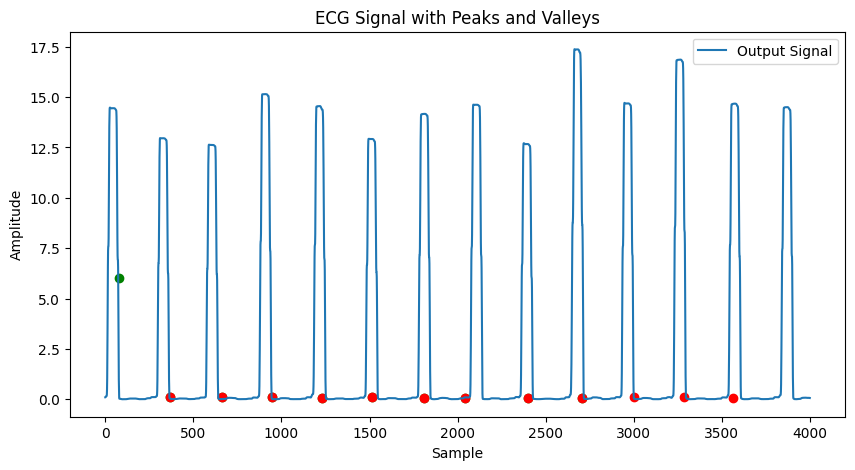

In [45]:
plt.figure(figsize = (10,5))
plt.plot(output_signal[3000:7000], label = 'Output Signal')
for peak in peaks[:10]:
    plt.scatter(peak, list(output_signal)[peak], color = 'green')
for idx, val in valleys[1:13]:
    plt.scatter(idx, val, color = 'red')
    
plt.title('ECG Signal with Peaks and Valleys')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

- Slicing 하고자 하는 구간에 대해서 [이전 R-peak점 : 빨간점]으로 설정하고자 하였음
- 구현한 함수가 제대로 기능하는지 검증하지 못하고 있는 한계 봉착